In [1]:
import os
import pandas as pd
from mplsoccer.pitch import Pitch, VerticalPitch
import numpy as np
from scipy.stats import binned_statistic_2d
np.random.seed(777)

Load the data

In [2]:
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

Pitch for binning the data

In [3]:
pitch = VerticalPitch(pitch_type='uefa', figsize=(16, 12), #pad_left=-10, pad_right=-10, pad_bottom=-10,
              half=True, line_zorder=2)

Bin the data into roughly 2 metre squaresm

In [4]:
pitch_range = [[pitch.dim.left, pitch.dim.right], [pitch.dim.bottom, pitch.dim.top]]
result = binned_statistic_2d(df.x, df.y, values=df.x, statistic='count', bins=(53, 34), expand_binnumbers=True,
                             range=pitch_range)

Identify outliers

In [5]:
result_percent = binned_statistic_2d(df.x, df.y, values=df.goal, statistic='mean', bins=(53, 34),
                                     expand_binnumbers=True,
                                     range=pitch_range)
xdim_outlier, ydim_outlier = ((np.nan_to_num(result_percent.statistic) >= 0.08) & (result.statistic < 20)).nonzero()
df_bins = pd.DataFrame({'bin_x': xdim_outlier + 1, 'bin_y': ydim_outlier + 1})
df['bin_x'] = result_percent.binnumber[0, :]
df['bin_y'] = result_percent.binnumber[1, :]
df_bins['outlier'] = True
df = df.merge(df_bins, on=['bin_x', 'bin_y'], how='left')

Generate some random data coordinates

In [6]:
x = np.arange(0, 105, 0.1)
y = np.arange(0, 68, 0.1)
x_random = np.random.choice(x, size=71400, replace=True)
y_random = np.random.choice(y, size=71400, replace=True)

Bin the random coordinates

In [7]:
result_random = binned_statistic_2d(x_random, y_random, values=x_random, statistic='count', bins=(53, 34),
                                    expand_binnumbers=True, range=pitch_range)
df_fake = pd.DataFrame({'x': x_random, 'y': y_random})
df_fake['bin_x'] = result_random.binnumber[0, :]
df_fake['bin_y'] = result_random.binnumber[1, :]

Keep only data in the fake data coordinates where there are fewer than 100 shots in the square

In [8]:
x_dim, y_dim = (result.statistic < 100).nonzero()
df_bins_to_add = pd.DataFrame({'bin_x': x_dim + 1, 'bin_y': y_dim + 1})
df_fake = df_fake.merge(df_bins_to_add, how='inner', on=['bin_x', 'bin_y'])

Remove the area infront of the goals

In [9]:
mask_infront_goal = (df_fake.bin_x > 52) & (df_fake.bin_y > 13) & (df_fake.bin_y < 22)
df_fake = df_fake[~mask_infront_goal].copy()

Remove area close to defensive goal (first 18 squares)

In [10]:
mask_defence = (df_fake.bin_x < 18)
df_fake = df_fake[~mask_defence].copy()

Keep area inside the penalty box

In [11]:
mask_pen_area = (df_fake.bin_x > 45) &  (df_fake.bin_x < 53) & (df_fake.bin_y > 7) & (df_fake.bin_y < 28)
mask_tight = (df_fake.bin_x == 53) & (df_fake.bin_y > 7) & (df_fake.bin_y < 28)
df_fake['tight'] = mask_tight
df_fake['pen_area'] = mask_pen_area

Sample 1000 of the fake shots

In [12]:
df_fake = df_fake[mask_tight | mask_pen_area].copy()
df_fake = df_fake.sample(1000)

Calculate the average goal probability from these areas (around 4%)

In [13]:
grids = df_fake[['bin_x', 'bin_y', 'pen_area']].drop_duplicates()
df = df.merge(grids, how='left')
mean_other_shots = df[df.pen_area == True].goal.mean()
print(mean_other_shots)

0.04176334106728538


If tight angle = No Goal

In [14]:
df_fake.loc[df_fake['tight'], 'goal'] = False

Otherwise set to the percentage above

In [15]:
goal1 = df_fake[df_fake.pen_area].groupby(['bin_x', 'bin_y']).apply(lambda x: x.sample(frac=mean_other_shots))
goal_idx1 = goal1.drop(['bin_x', 'bin_y'], axis=1).reset_index().level_2
df_fake.loc[df_fake.index.isin(goal_idx1), 'goal'] = True
df_fake.loc[df_fake.goal.isnull(), 'goal'] = False
df_fake['goal'] = df_fake['goal'].astype(bool)
df_fake.reset_index(drop=True, inplace=True)

Show areas with fake shots

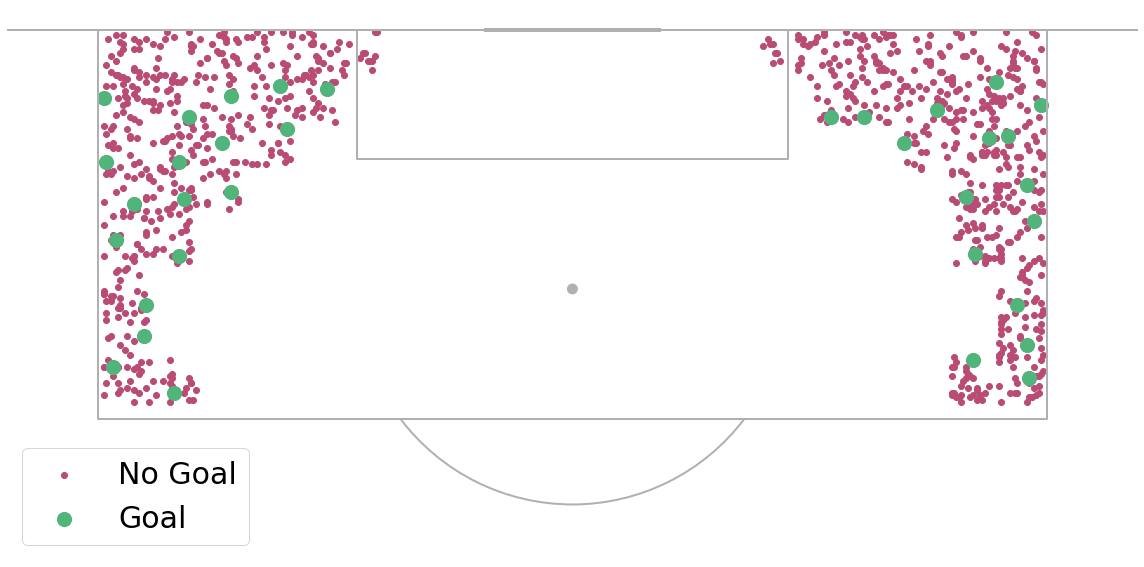

In [16]:
pitch = VerticalPitch(pitch_type='uefa', pad_left=-10, pad_right=-10, pad_bottom=-30, pad_top=1,
              half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
pitch.scatter(df_fake[~df_fake['goal']].x, df_fake[~df_fake['goal']].y, color='#b94b75', label='No Goal', ax=ax)
pitch.scatter(df_fake[df_fake['goal']].x, df_fake[df_fake['goal']].y, color='#50b47b', s=200, label='Goal', ax=ax)
ax.legend(fontsize=30)
fig.savefig(os.path.join(cwd, 'figures', '20_fake_data_added.png'), bbox_inches = 'tight', pad_inches = 0.2)

Fill in the other features from a randomly sampled row in the data from the same area (penalty area/ other)

In [17]:
cols_in_lgbm_model = ['shot_type_name', 'counter_attack', 'fast_break', 'strong_foot', 'body_part_name',
                      'assist_type', 'pass_end_y', 'pass_end_x', 'pass_switch', 'pass_cross', 'pass_cut_back',
                      'pass_height_name', 'pass_technique_name', 'carry_length', 'competition_gender',
                      'shot_one_on_one', 'shot_open_goal', 'under_pressure', 'area_shot', 'area_goal', 'n_angle',
                      'goalkeeper_x', 'goalkeeper_y', 'smart_pass', 'match_week', 'H_A_column', 'competition_type',
                      'players', 'players_rival', 'match_moment', 'shot_number', 'shot_zone_number', 'shot_player_number',
                      'shot_zone_player_number', 'competition_part']

In [18]:
df_pen = df.loc[df.pen_area == True, cols_in_lgbm_model].copy()
df_pen

,shot_type_name,counter_attack,fast_break,strong_foot,body_part_name,assist_type,pass_end_y,pass_end_x,pass_switch,pass_cross,...,H_A_column,competition_type,players,players_rival,match_moment,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number,competition_part
45,open_play,False,False,False,Right Foot,pass,46.835,91.9625,False,False,...,Home Team,League,11.0,11.0,0-15,1.0,1.0,1.0,1.0,start
52,open_play,False,False,False,Left Foot,pass,3.740,88.5500,True,False,...,Home Team,League,11.0,11.0,0-15,1.0,1.0,1.0,1.0,start
81,open_play,False,False,True,Right Foot,pass,62.050,61.2500,False,False,...,Away Team,League,11.0,11.0,0-15,1.0,1.0,1.0,1.0,start
109,free_kick,False,False,True,Right Foot,pass,49.300,91.0000,False,False,...,Home Team,Cup,11.0,11.0,0-15,1.0,1.0,1.0,1.0,group
112,open_play,False,False,True,Right Foot,pass,24.140,77.0875,False,False,...,Home Team,League,11.0,11.0,0-15,1.0,1.0,1.0,1.0,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65447,throw_in,False,False,True,Right Foot,pass,NaN,NaN,False,False,...,Home Team,League,11.0,11.0,75-90,13.0,1.0,1.0,1.0,middle
65463,open_play,True,True,True,Left Foot,pass,NaN,NaN,False,False,...,Away Team,League,11.0,11.0,75-90,21.0,6.0,2.0,1.0,final
65466,open_play,False,False,False,Left Foot,recovery,NaN,NaN,None,None,...,Home Team,League,11.0,11.0,75-90,9.0,4.0,1.0,1.0,final
65489,open_play,False,False,True,Right Foot,pass,NaN,NaN,False,False,...,Away Team,League,11.0,11.0,75-90,13.0,1.0,1.0,1.0,final


In [19]:
df_pen = df_pen.sample(n=1000, replace=True).reset_index(drop=True)
df_pen

,shot_type_name,counter_attack,fast_break,strong_foot,body_part_name,assist_type,pass_end_y,pass_end_x,pass_switch,pass_cross,...,H_A_column,competition_type,players,players_rival,match_moment,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number,competition_part
0,open_play,False,False,False,Left Foot,pass,NaN,NaN,False,False,...,Away Team,League,11.0,11.0,75-90,21.0,2.0,2.0,1.0,middle
1,open_play,False,False,False,Left Foot,pass,7.65,96.2500,False,False,...,Home Team,League,11.0,11.0,60-75,9.0,1.0,4.0,1.0,middle
2,corner,False,False,False,Other,rebound,NaN,NaN,None,None,...,Home Team,League,11.0,11.0,60-75,11.0,3.0,1.0,1.0,final
3,open_play,True,False,True,Right Foot,pass,NaN,NaN,False,False,...,Home Team,League,11.0,11.0,60-75,14.0,2.0,2.0,1.0,middle
4,corner,False,False,False,Other,pass,43.35,99.4875,False,False,...,Away Team,League,11.0,11.0,0-15,2.0,1.0,1.0,1.0,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,open_play,False,False,True,Right Foot,pass,NaN,NaN,False,False,...,Home Team,League,11.0,11.0,45-60,6.0,1.0,2.0,1.0,middle
996,open_play,False,False,True,Right Foot,pass,NaN,NaN,False,False,...,Away Team,League,11.0,11.0,30-45,4.0,1.0,1.0,1.0,final
997,throw_in,False,False,True,Left Foot,pass,55.59,83.3000,False,False,...,Home Team,Cup,11.0,11.0,60-75,22.0,14.0,6.0,5.0,group
998,open_play,False,False,True,Left Foot,pass,NaN,NaN,False,False,...,Away Team,League,11.0,11.0,60-75,19.0,4.0,2.0,1.0,start


In [20]:
df_fake = df_fake.merge(df_pen, left_index=True, right_index=True)
df_fake

,x,y,bin_x,bin_y,tight,pen_area,goal,shot_type_name,counter_attack,fast_break,...,H_A_column,competition_type,players,players_rival,match_moment,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number,competition_part
0,102.1,46.9,52,24,False,True,False,open_play,False,False,...,Away Team,League,11.0,11.0,75-90,21.0,2.0,2.0,1.0,middle
1,89.8,16.8,46,9,False,True,False,open_play,False,False,...,Home Team,League,11.0,11.0,60-75,9.0,1.0,4.0,1.0,middle
2,103.9,44.9,53,23,True,False,False,corner,False,False,...,Home Team,League,11.0,11.0,60-75,11.0,3.0,1.0,1.0,final
3,102.8,50.0,52,26,False,True,False,open_play,True,False,...,Home Team,League,11.0,11.0,60-75,14.0,2.0,2.0,1.0,middle
4,101.9,14.2,52,8,False,True,False,corner,False,False,...,Away Team,League,11.0,11.0,0-15,2.0,1.0,1.0,1.0,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,98.6,51.8,50,26,False,True,False,open_play,False,False,...,Home Team,League,11.0,11.0,45-60,6.0,1.0,2.0,1.0,middle
996,104.4,43.5,53,22,True,False,False,open_play,False,False,...,Away Team,League,11.0,11.0,30-45,4.0,1.0,1.0,1.0,final
997,103.6,15.3,53,8,True,False,False,throw_in,False,False,...,Home Team,Cup,11.0,11.0,60-75,22.0,14.0,6.0,5.0,group
998,103.0,21.7,52,11,False,True,False,open_play,False,False,...,Away Team,League,11.0,11.0,60-75,19.0,4.0,2.0,1.0,start


In [21]:
df_fake.drop(['bin_x', 'bin_y', 'tight', 'pen_area'], axis=1, inplace=True)

Check before adding fake data. Less smooth

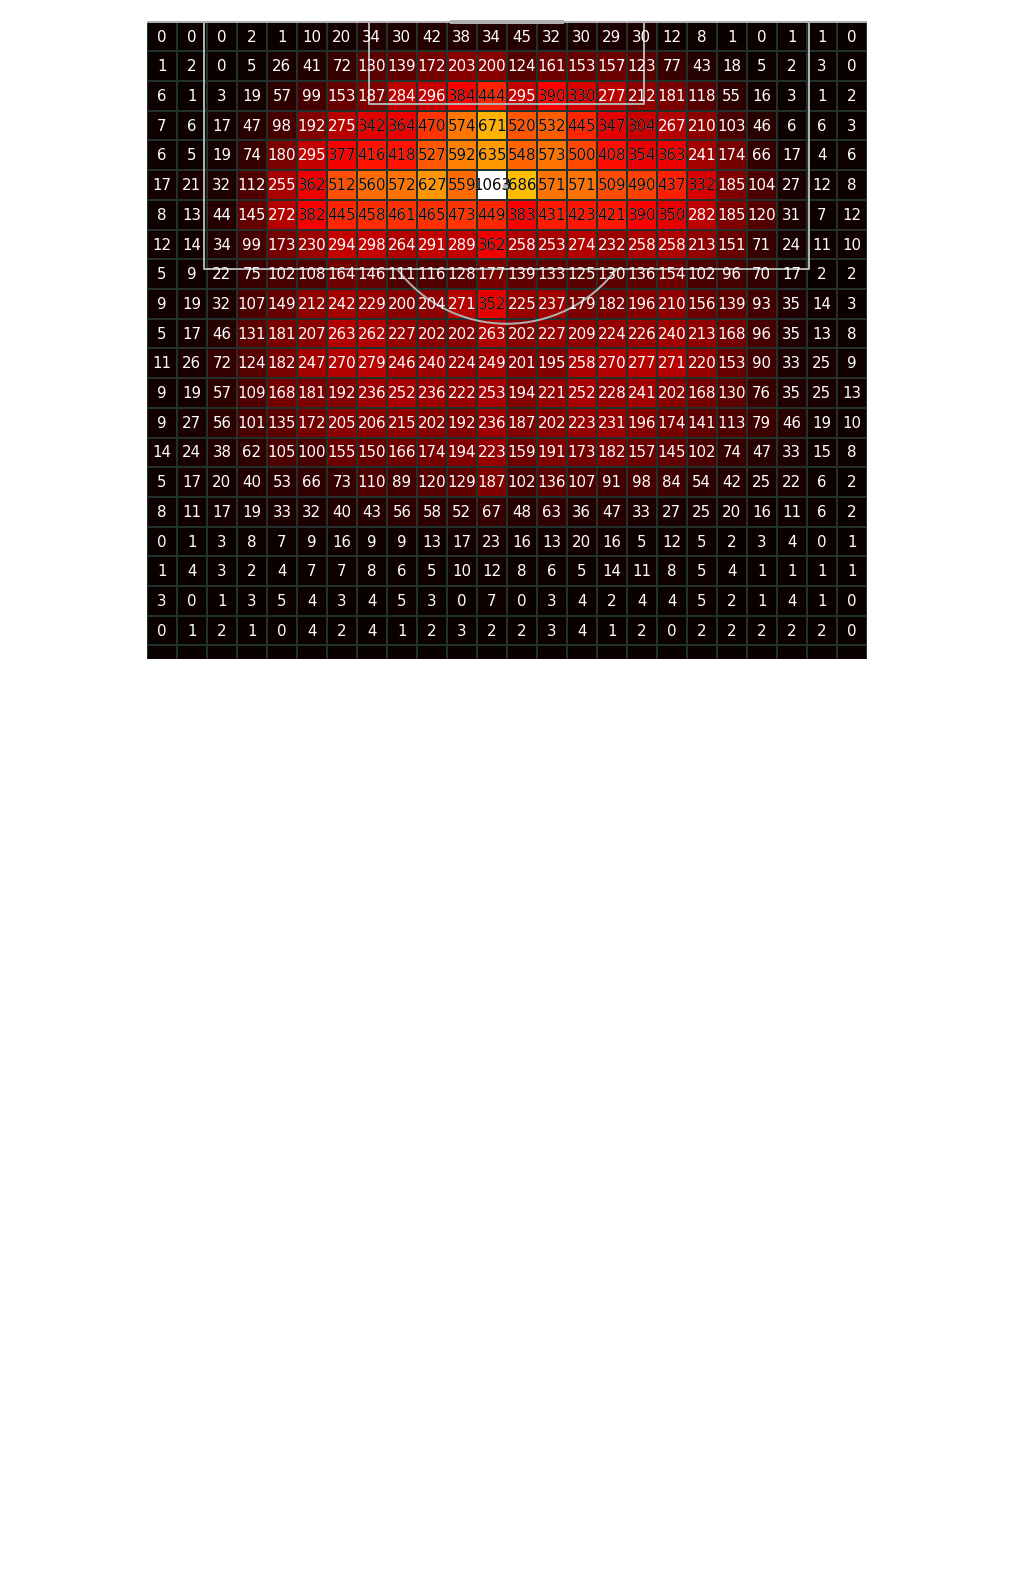

In [22]:
pitch = VerticalPitch(pitch_type='uefa', pad_left=-10, pad_right=-10, pad_bottom=-10, pad_top=1,
              half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
bs = pitch.bin_statistic(df.x, df.y, statistic='count', bins=(53, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = (bs['statistic']).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 300
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
fig.savefig(os.path.join(cwd, 'figures', '19_number_of_shots_by_location.png'), bbox_inches = 'tight', pad_inches = 0.2)

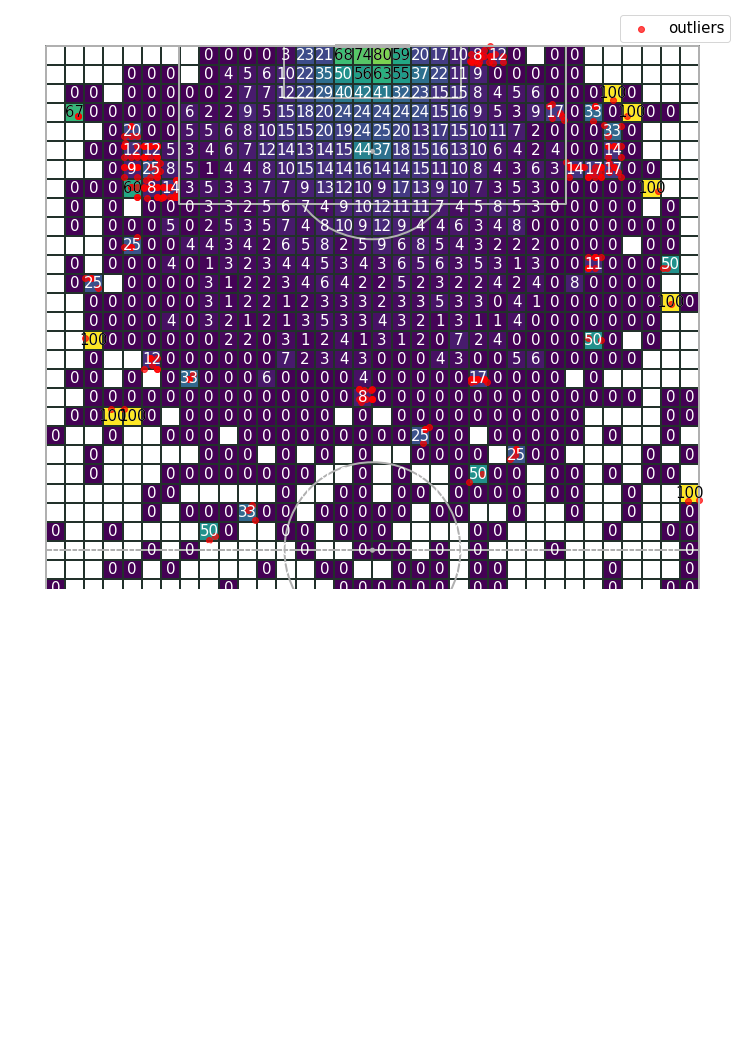

In [23]:
pitch = VerticalPitch(pitch_type='uefa', #pad_left=-10, pad_right=-10, pad_bottom=-10,
              half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
bs = pitch.bin_statistic(df.x, df.y, values=df.goal,  statistic='mean', bins=(53, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = np.round(bs['statistic'] * 100., 0).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 50
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
pitch.scatter(df[df['outlier']==True].x, df[df['outlier']==True].y, ax=ax, color='red', label='outliers', alpha=0.7)
ax.legend(fontsize=15)
fig.savefig(os.path.join(cwd, 'figures', '18_outliers.png'), bbox_inches = 'tight', pad_inches = 0.2)

Check after adding fake data - scoring percentages

In [24]:
df_with_fake= pd.concat([df_fake[['x', 'y', 'goal']], df.loc[~(df.outlier == True), ['x', 'y', 'goal']]])
df_with_fake

,x,y,goal
0,102.10,46.90,False
1,89.80,16.80,False
2,103.90,44.90,False
3,102.80,50.00,False
4,101.90,14.20,False
...,...,...,...
65550,93.45,34.00,False
65551,91.35,46.92,False
65552,92.40,27.20,False
65553,93.45,20.40,False


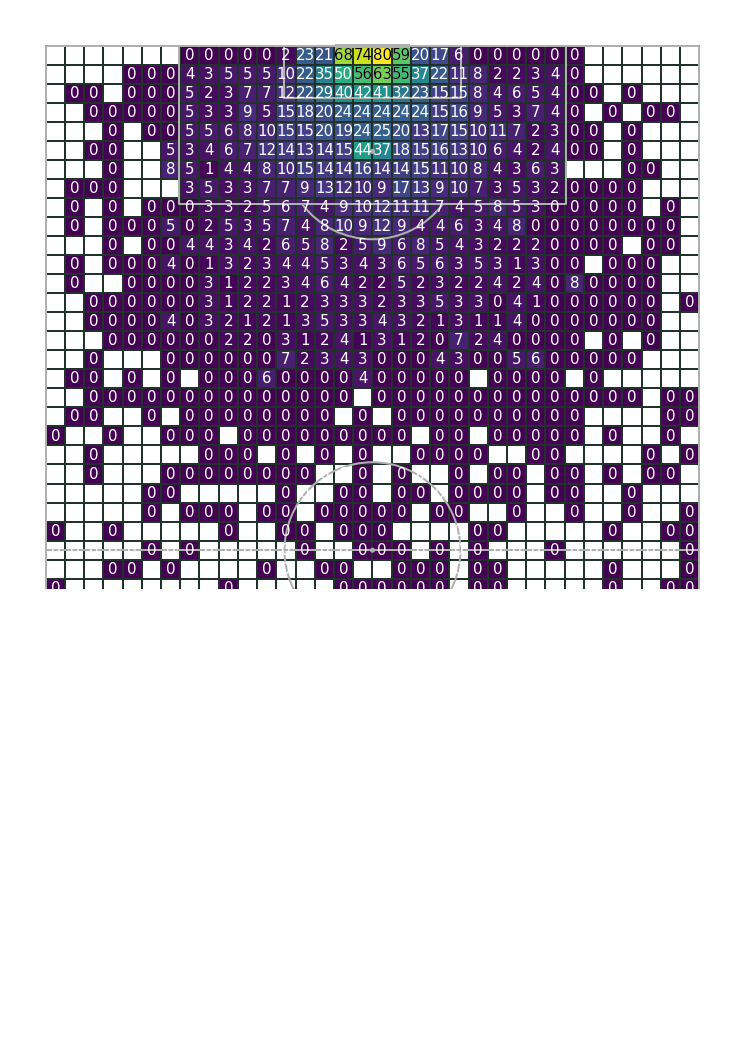

In [25]:
pitch = VerticalPitch(pitch_type='uefa', half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
bs = pitch.bin_statistic(df_with_fake.x, df_with_fake.y, values=df_with_fake.goal,  statistic='mean', bins=(53, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = np.round(bs['statistic'] * 100., 0).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 50
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
fig.savefig(os.path.join(cwd, 'figures', '21_raw_goal_probabilities_with_fake_and_removing_outliers.png'),
            bbox_inches = 'tight', pad_inches = 0.2)

# Save fake data

In [26]:
df_fake.to_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))

In [27]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   x                        1000 non-null   float64
 1   y                        1000 non-null   float64
 2   goal                     1000 non-null   bool   
 3   shot_type_name           1000 non-null   object 
 4   counter_attack           1000 non-null   bool   
 5   fast_break               1000 non-null   bool   
 6   strong_foot              1000 non-null   bool   
 7   body_part_name           1000 non-null   object 
 8   assist_type              1000 non-null   object 
 9   pass_end_y               248 non-null    float64
 10  pass_end_x               248 non-null    float64
 11  pass_switch              695 non-null    object 
 12  pass_cross               695 non-null    object 
 13  pass_cut_back            695 non-null    object 
 14  pass_height_name         

# Save shot dataset. Remove outliers and extra columns

In [28]:
print('Outliers removed;', df.outlier.notnull().sum())
df = df[df.outlier.isnull()].copy()
df.drop(['bin_x', 'bin_y', 'outlier', 'pen_area'], axis=1, inplace=True)
df.to_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

Outliers removed; 228
